In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#한글폰트 깔기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (32.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155013 files and di

# 데이터 살펴보기

In [ ]:
mirae = pd.read_csv('/content/drive/MyDrive/미래에셋/mirae_data.csv', )
mirae.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4,22,33,34,35,39,40,41,45,46,47,61,62,80,91,92,93,97,98,99,103,104,105,119,120,138,149,150,151,155,156,157,161,162,163,177,178,196,207,208,209,213,214,215,219,220,221,235,236,254,265,266,267,271,272,273,277,278,279,293,294,312,323,324,325,329,330,331,335,336,337,351,352,370,381,382,383,387,388,389,393,394,395,409,410,428,439,440,441,445,446,447,451,452,453,467,468,486,497,498,499,503,504,505,509,510,511,525,526,544,555,556,557,561,562,563,567,568,569,583,584,602,613,614,615,619,620,621,625,626,627,641,642,660,671,672,673,677,678,679,683,684,685) have mixed types.Specify dtype option on import or set low_memory=False.



,성별,연령,최초계좌개설일,고객등급_202105,주거래상품_202105,주거래매체_202105,국내주식자산_202105,해외주식자산_202105,상품자산_202105,보유종목수_202105,국내주식매수_202105,국내주식매도_202105,해외주식매수_202105,해외주식매도_202105,거래종목수_202105,m.Stock_접속일수_202105,m.Global_접속일수_202105,m.All_접속일수_202105,퇴직연금자산_202105,개인연금자산_202105,코스피거래비중_202105,코스닥거래비중_202105,선호시장_202105,손절횟수_202105,이익실현횟수_202105,DayTrading비중_202105,Swing비중_202105,Buy&Hold비중_202105,시총1천억미만선호도_202105,시총1천억이상3천억미만선호도_202105,시총3천억이상1조미만선호도_202105,시총1조이상선호도_202105,신용_202105,주식보유1위종목_202105,주식보유2위종목_202105,주식보유3위종목_202105,주식보유1위금액_202105,주식보유2위금액_202105,주식보유3위금액_202105,주식매수1위종목_202105,...,코스닥거래비중_202006,선호시장_202006,손절횟수_202006,이익실현횟수_202006,DayTrading비중_202006,Swing비중_202006,Buy&Hold비중_202006,시총1천억미만선호도_202006,시총1천억이상3천억미만선호도_202006,시총3천억이상1조미만선호도_202006,시총1조이상선호도_202006,신용_202006,주식보유1위종목_202006,주식보유2위종목_202006,주식보유3위종목_202006,주식보유1위금액_202006,주식보유2위금액_202006,주식보유3위금액_202006,주식매수1위종목_202006,주식매수2위종목_202006,주식매수3위종목_202006,주식매수1위금액_202006,주식매수2위금액_202006,주식매수3위금액_202006,주식매도1위종목_202006,주식매도2위종목_202006,주식매도3위종목_202006,주식매도1위금액_202006,주식매도2위금액_202006,주식매도3위금액_202006,Dr.Big의국내주식_202006,Dr.Big의해외주식_202006,Dr.Big의국내ETF_202006,Dr.Big의펀드연금_202006,Dr.Big의투자진단_202006,Dr.Big의시그널_202006,뉴스로종목포착_202006,해외ETF트렌드_202006,초고수의선택_202006,주간상품TOP10_202006
0,1.0,20대이하,200604.0,A,펀드,2,81000000.0,0.000000e+00,0.000000e+00,0.0,0.0,81000000.0,0.0,0.0,0.0,9.0,0.0,4.0,0.0,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27000000.0,0,0,0,38000000.0,26000000.0,11000000.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,20대이하,200610.0,A,주식,2,18000000.0,0.000000e+00,0.000000e+00,6.0,9000000.0,8500000.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.000000e+00,95.0,5.0,코스피,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,A097230,A302440,A015760,8000000.0,2600000.0,1500000.0,A361670,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,60대이상,200001.0,D,주식,2,39000000.0,0.000000e+00,0.000000e+00,1.0,2300000.0,0.0,0.0,0.0,2.0,21.0,0.0,0.0,0.0,0.000000e+00,82.0,18.0,코스피,33.0,38.0,1.0,97.0,0.0,0.0,4.0,13.0,82.0,0.0,A298050,A298050,A066570,13000000.0,12000000.0,5600000.0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,60대이상,200001.0,S,주식,1,150000000.0,0.000000e+00,2.700000e+09,17.0,130000000.0,100000000.0,0.0,0.0,23.0,29.0,9.0,0.0,0.0,0.000000e+00,73.0,27.0,코스피,27.0,39.0,3.0,94.0,1.0,1.0,8.0,26.0,66.0,4400000.0,A011200,A004020,A005930,18000000.0,15000000.0,12000000.0,A004020,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,60대이상,200001.0,V,주식,1,290000000.0,2.500000e+09,9.900000e+10,11.0,15000000.0,6600000.0,7100000.0,0.0,0.0,4.0,1.0,0.0,0.0,8.700000e+10,95.0,5.0,코스피,0.0,0.0,0.0,85.0,14.0,0.0,0.0,0.0,100.0,0.0,A005930,A006400,A005935,55000000.0,54000000.0,35000000.0,A035720,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,35000000.0,33000000.0,23000000.0,0,0,0,0.0,0.0,0.0,0,0,0,710000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 전처리

### 1. 수익률 칼럼 만들기

In [ ]:
#매달 '국내 주식 매도'와 '국내 주식 매수' 칼럼을 모아놓음
maesu_col = []
maedo_col = []
for x in list(mirae.columns):
  if '국내주식매수' in x:
    maesu_col.append(x)
  elif '국내주식매도' in x:
    maedo_col.append(x)

### 수익률 계산 방법

1년동안의 수익률을 계산한 방법은 다음과 같다.

- 총 매수 금액 : 초기에 가지고 있던 자산(국내주식자산_202006) + 1년동안 매수한 모든 금액

- 총 매도 금액 : 1년동안 매도한 모든 금액 + 최종적으로 가지고 있는 자산(국내주식자산_202105)

- 수익률 : (총 매도 금액 - 총 매수 금액) / 총 매수 금액

In [ ]:
mirae['총매수금액'] = mirae['국내주식자산_202006']
mirae['총매도금액'] = mirae['국내주식자산_202105']

#총 매수금액, 총 매도금액을 계산
for i in maesu_col[:-1]:
  mirae['총매수금액'] = mirae['총매수금액'] + mirae[i]
for i in maedo_col[1:]:
  mirae['총매도금액'] = mirae['총매도금액'] + mirae[i]

#수익률 계산
mirae['수익률'] = (mirae['총매도금액'] - mirae['총매수금액']) / mirae['총매수금액']

#수익률이 너무 크게 계산되거나(수익률 50% 이상) 수익률이 너무 작게 계산되면 제외(수익률 -50% 이하)
def overone(x):
  if float(x) >= 0.5 or float(x) <= -0.5:
    return None
  return float(x) * 100
mirae['수익률'] = mirae['수익률'].apply(overone)

del mirae['총매도금액']
del mirae['총매수금액']

### 2. 종목 코드를 종목명으로 바꾸기


In [ ]:
#종목 코드 만들어주는 함수 구현
def make_code(x):
  x = str(x)
  return 'A' + '0'*(6-len(x)) + x

#종목 코드와 종목명 크롤링하기
code_data = pd.read_html('https://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header = 0)[0]
code_data = code_data[['종목코드','회사명']]
code_data['종목코드'] = code_data['종목코드'].apply(make_code)
print(code_data)

         종목코드        회사명
0     A004840      DRB동일
1     A155660        DSR
2     A078930         GS
3     A001250      GS글로벌
4     A294870  HDC현대산업개발
...       ...        ...
2454  A199800         툴젠
2455  A217880         틸론
2456  A222670   플럼라인생명과학
2457  A331660   한국미라클피플사
2458  A212310        휴벡셀

[2459 rows x 2 columns]


In [ ]:
#주식 종목 관련 종목 코드로 적혀진 모든 칼럼을 모아놓음
mirae_stock_list = []
mirae_columns = list(mirae.columns)
for x in mirae_columns:
  if '주식보유' in x or '주식매수' in x or '주식매도' in x:
    if len(x) > 13 and not '금액' in x:
      mirae_stock_list.append(x)
mirae_stock_list

In [ ]:
#종목 코드를 종목명으로 치환
for x in mirae_stock_list:
  mirae[x] = pd.merge(mirae, code_data, how = 'left', left_on = x, right_on = '종목코드')['회사명']
mirae.head()

,Unnamed: 0,성별,연령,최초계좌개설일,고객등급_202105,주거래상품_202105,주거래매체_202105,국내주식자산_202105,해외주식자산_202105,상품자산_202105,보유종목수_202105,국내주식매수_202105,국내주식매도_202105,해외주식매수_202105,해외주식매도_202105,거래종목수_202105,m.Stock_접속일수_202105,m.Global_접속일수_202105,m.All_접속일수_202105,퇴직연금자산_202105,개인연금자산_202105,코스피거래비중_202105,코스닥거래비중_202105,선호시장_202105,손절횟수_202105,이익실현횟수_202105,DayTrading비중_202105,Swing비중_202105,Buy&Hold비중_202105,시총1천억미만선호도_202105,시총1천억이상3천억미만선호도_202105,시총3천억이상1조미만선호도_202105,시총1조이상선호도_202105,신용_202105,주식보유1위종목_202105,주식보유2위종목_202105,주식보유3위종목_202105,주식보유1위금액_202105,주식보유2위금액_202105,주식보유3위금액_202105,...,코스닥거래비중_202006,선호시장_202006,손절횟수_202006,이익실현횟수_202006,DayTrading비중_202006,Swing비중_202006,Buy&Hold비중_202006,시총1천억미만선호도_202006,시총1천억이상3천억미만선호도_202006,시총3천억이상1조미만선호도_202006,시총1조이상선호도_202006,신용_202006,주식보유1위종목_202006,주식보유2위종목_202006,주식보유3위종목_202006,주식보유1위금액_202006,주식보유2위금액_202006,주식보유3위금액_202006,주식매수1위종목_202006,주식매수2위종목_202006,주식매수3위종목_202006,주식매수1위금액_202006,주식매수2위금액_202006,주식매수3위금액_202006,주식매도1위종목_202006,주식매도2위종목_202006,주식매도3위종목_202006,주식매도1위금액_202006,주식매도2위금액_202006,주식매도3위금액_202006,Dr.Big의국내주식_202006,Dr.Big의해외주식_202006,Dr.Big의국내ETF_202006,Dr.Big의펀드연금_202006,Dr.Big의투자진단_202006,Dr.Big의시그널_202006,뉴스로종목포착_202006,해외ETF트렌드_202006,초고수의선택_202006,주간상품TOP10_202006
0,0,1.0,20대이하,200604.0,A,펀드,2,81000000.0,0.000000e+00,0.000000e+00,0.0,0.0,81000000.0,0.0,0.0,0.0,9.0,0.0,4.0,0.0,0.000000e+00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27000000.0,NaN,NaN,NaN,38000000.0,26000000.0,11000000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,20대이하,200610.0,A,주식,2,18000000.0,0.000000e+00,0.000000e+00,6.0,9000000.0,8500000.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.000000e+00,95.0,5.0,코스피,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,한진중공업,SK바이오사이언스,한국전력공사,8000000.0,2600000.0,1500000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,60대이상,200001.0,D,주식,2,39000000.0,0.000000e+00,0.000000e+00,1.0,2300000.0,0.0,0.0,0.0,2.0,21.0,0.0,0.0,0.0,0.000000e+00,82.0,18.0,코스피,33.0,38.0,1.0,97.0,0.0,0.0,4.0,13.0,82.0,0.0,효성첨단소재,효성첨단소재,LG전자,13000000.0,12000000.0,5600000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,60대이상,200001.0,S,주식,1,150000000.0,0.000000e+00,2.700000e+09,17.0,130000000.0,100000000.0,0.0,0.0,23.0,29.0,9.0,0.0,0.0,0.000000e+00,73.0,27.0,코스피,27.0,39.0,3.0,94.0,1.0,1.0,8.0,26.0,66.0,4400000.0,HMM,현대제철,삼성전자,18000000.0,15000000.0,12000000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,60대이상,200001.0,V,주식,1,290000000.0,2.500000e+09,9.900000e+10,11.0,15000000.0,6600000.0,7100000.0,0.0,0.0,4.0,1.0,0.0,0.0,8.700000e+10,95.0,5.0,코스피,0.0,0.0,0.0,85.0,14.0,0.0,0.0,0.0,100.0,0.0,삼성전자,삼성SDI,NaN,55000000.0,54000000.0,35000000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,35000000.0,33000000.0,23000000.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,710000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#csv로 저장하기
mirae.to_csv('/content/drive/MyDrive/미래에셋/mirae_stockname.csv')

### 3. 업종(소분류, 중분류) 불러오기 - NAVER 증권 기준

In [ ]:
stock_name_df = []
single_stock_df = []
stocks = []

In [ ]:
#네이버 증권의 업종 분류(소분류) 가져오는 함수 만들기
def stock_append(i):
  url = "https://finance.naver.com/sise/sise_group_detail.nhn?type=upjong&no="+str(i)

  res = requests.get(url)
  soup = BeautifulSoup(res.text, 'lxml')
  stock_name = soup.find("table", attrs={"class": "type_1"}).find_all('td')[1].text.strip() #업종명
  stock_list = soup.find("table", attrs={"class": "type_5"}).find("tbody").find_all('tr') #그 업종에 속한 종목 리스트
  for stock in stock_list:
    if len(stock) > 1 :
      single_stock = stock.get_text().strip().split()[0]
      stock_name_df.append(stock_name)
      single_stock_df.append(single_stock)
      stocks.append([stock_name, single_stock])

#업종들 페이지들을 크롤링하여 정보 가져오기(소분류)
for i in range(261,339):
  stock_append(i)
stock_append(25)

In [ ]:
#업종이 겹치는 종목들 빼기(두번 이상 등장하는 종목)
stock_name_pd = pd.DataFrame(data = stock_name_df, columns = ['업종'])
single_stock_pd = pd.DataFrame(data = single_stock_df, columns = ['회사명'])
df_stock = pd.DataFrame(data = stocks, columns = ['업종','회사명'])
df_stock = df_stock.iloc[list(single_stock_pd.drop_duplicates().index),:].reset_index(drop = True)

In [ ]:
df_stock.head()

,업종,회사명
0,제약,국전약품
1,제약,경남제약
2,제약,SK바이오사이언스
3,제약,조아제약
4,제약,안트로젠


In [ ]:
#업종 중분류 딕셔너리로 만들기(네이버 증권 기준)
upjong_dict = {'에너지':['에너지장비및서비스','석유와가스'],'소재':['화학','포장재','비철금속','철강','종이와목재'],
      '자본재':['우주항공과국방','건축제품','건축자재','건설','가구','전기장비','복합기업','기계','조선', '무역회사와판매업체'],
      '상업서비스와공급품': ['상업서비스와공급품'], '운송':['항공화물운송과물류', '항공사', '해운사', '도로와철도운송', '운송인프라'],
      '자동차와부품':['자동차부품', '자동차'],'내구소비재와의류':['가정용기기와용품', '레저용장비와제품', '섬유,의류,신발,호화품', '화장품', '문구류'],
      '호텔,레스토랑,레저등':['호텔,레스토랑,레저'],'미디어':['광고', '방송과엔터테인먼트', '출판', '양방향미디어와서비스'],
      '소매':['판매업체', '인터넷과카탈로그소매', '백화점과일반상점', '전문소매'],'교육서비스':['교육서비스'],
      '식품과기본식료품소매': ['식품과기본식료품소매'],'식품,음료,담배':['식품', '담배', '음료'],'가정용품과개인용품':['가정용품'],
      '건강관리장비와서비스':['건강관리장비와용품', '건강관리업체및서비스', '건강관리기술'],'제약과생물공학':['생물공학', '제약', '생명과학도구및서비스'],
      '은행':['은행'],'증권':['증권'],'다각화된금융':['창업투자', '카드', '기타금융'],'보험':['손해보험', '생명보험'],'부동산':['부동산'],
      '소프트웨어와서비스':['소프트웨어', 'IT서비스', '게임엔터테인먼트'],'기술하드웨어와장비':['통신장비', '핸드셋', '컴퓨터와주변기기', '전자장비와기기', '사무용전자제품'],
      '반도체와반도체장비':['반도체와반도체장비'],'전자와전기제품':['전자제품', '전기제품'],'디스플레이':['디스플레이패널','디스플레이장비및부품'],
      '통신서비스':['무선통신서비스','다각화된통신서비스'],'유틸리티':['가스유틸리티', '전기유틸리티', '복합유틸리티', '독립전력생산및에너지거래'],'기타':['기타']}

In [ ]:
#위의 딕셔너리 dataframe으로 만들기
upjong_list = []
for key, values in upjong_dict.items():
  for value in values:
    upjong_list.append([key,value])
middle_df = pd.DataFrame(upjong_list, columns = ['중분류','소분류'])
middle_df

,중분류,소분류
0,에너지,에너지장비및서비스
1,에너지,석유와가스
2,소재,화학
3,소재,포장재
4,소재,비철금속
...,...,...
74,유틸리티,가스유틸리티
75,유틸리티,전기유틸리티
76,유틸리티,복합유틸리티
77,유틸리티,독립전력생산및에너지거래


In [ ]:
#위에서 구한 업종(소분류)와 종목 dataframe을 중분류와 합치기
upjong = pd.merge(df_stock, middle_df, how = 'left', left_on = '업종', right_on = '소분류')[['회사명','중분류','소분류']]

In [ ]:
upjong.head()

,회사명,중분류,소분류
0,국전약품,제약과생물공학,제약
1,경남제약,제약과생물공학,제약
2,SK바이오사이언스,제약과생물공학,제약
3,조아제약,제약과생물공학,제약
4,안트로젠,제약과생물공학,제약


In [ ]:
#업종 정보 저장해두기
upjong.to_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong.csv')

### 4. 종목별 업종 원래 데이터와 합치기 - NAVER 증권 기준

In [ ]:
#매수 칼럼들만 따질 것이므로 매수 관련 종목 칼럼만 따로 빼온다.
mirae_maesu_list = []
mirae_columns = list(mirae.columns)
for x in mirae_columns:
  if '주식매수' in x:
    if len(x) > 13:
      mirae_maesu_list.append(x)
mirae = mirae[mirae_maesu_list]

In [ ]:
#업종 정보 불러오기
upjong = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong.csv')
#매수 종목 이름에 따른 업종 분류(소분류, 중분류)만 뽑아오기 위해 new_df를 만든다.
new_df = pd.DataFrame([])

#RAM의 크기 때문에 각 달마다 매수 탑 3 종목, 금액, 업종(중분류, 소분류)만 따로 dataframe을 만듬
for maesu in mirae_maesu_list:
  if '금액' not in maesu:
    new_df = pd.concat([new_df, pd.merge(mirae, upjong, how = 'left', left_on = maesu, right_on = '회사명')[[maesu, '중분류','소분류']].rename(columns = {maesu:maesu, '중분류':maesu+'_중분류','소분류':maesu+'_소분류'})], axis = 1)
  else:
    new_df = pd.concat([new_df, mirae[[maesu]]], axis = 1)

new_df.head()

,주식매수1위종목_202105,주식매수1위종목_202105_중분류,주식매수1위종목_202105_소분류,주식매수2위종목_202105,주식매수2위종목_202105_중분류,주식매수2위종목_202105_소분류,주식매수3위종목_202105,주식매수3위종목_202105_중분류,주식매수3위종목_202105_소분류,주식매수1위금액_202105,주식매수2위금액_202105,주식매수3위금액_202105,주식매수1위종목_202104,주식매수1위종목_202104_중분류,주식매수1위종목_202104_소분류,주식매수2위종목_202104,주식매수2위종목_202104_중분류,주식매수2위종목_202104_소분류,주식매수3위종목_202104,주식매수3위종목_202104_중분류,주식매수3위종목_202104_소분류,주식매수1위금액_202104,주식매수2위금액_202104,주식매수3위금액_202104,주식매수1위종목_202103,주식매수1위종목_202103_중분류,주식매수1위종목_202103_소분류,주식매수2위종목_202103,주식매수2위종목_202103_중분류,주식매수2위종목_202103_소분류,주식매수3위종목_202103,주식매수3위종목_202103_중분류,주식매수3위종목_202103_소분류,주식매수1위금액_202103,주식매수2위금액_202103,주식매수3위금액_202103,주식매수1위종목_202102,주식매수1위종목_202102_중분류,주식매수1위종목_202102_소분류,주식매수2위종목_202102,...,주식매수3위종목_202009_소분류,주식매수1위금액_202009,주식매수2위금액_202009,주식매수3위금액_202009,주식매수1위종목_202008,주식매수1위종목_202008_중분류,주식매수1위종목_202008_소분류,주식매수2위종목_202008,주식매수2위종목_202008_중분류,주식매수2위종목_202008_소분류,주식매수3위종목_202008,주식매수3위종목_202008_중분류,주식매수3위종목_202008_소분류,주식매수1위금액_202008,주식매수2위금액_202008,주식매수3위금액_202008,주식매수1위종목_202007,주식매수1위종목_202007_중분류,주식매수1위종목_202007_소분류,주식매수2위종목_202007,주식매수2위종목_202007_중분류,주식매수2위종목_202007_소분류,주식매수3위종목_202007,주식매수3위종목_202007_중분류,주식매수3위종목_202007_소분류,주식매수1위금액_202007,주식매수2위금액_202007,주식매수3위금액_202007,주식매수1위종목_202006,주식매수1위종목_202006_중분류,주식매수1위종목_202006_소분류,주식매수2위종목_202006,주식매수2위종목_202006_중분류,주식매수2위종목_202006_소분류,주식매수3위종목_202006,주식매수3위종목_202006_중분류,주식매수3위종목_202006_소분류,주식매수1위금액_202006,주식매수2위금액_202006,주식매수3위금액_202006
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140000000.0,72000000.0,37000000.0,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,삼영에스앤씨,기술하드웨어와장비,전자장비와기기,NaN,NaN,NaN,NaN,NaN,NaN,2700000.0,2500000.0,860000.0,삼영에스앤씨,기술하드웨어와장비,전자장비와기기,NaN,NaN,NaN,NaN,NaN,NaN,2700000.0,2500000.0,860000.0,SK바이오사이언스,제약과생물공학,제약,엔시스,기술하드웨어와장비,전자장비와기기,NaN,NaN,NaN,1300000.0,1000000.0,990000.0,홈센타홀딩스,자본재,건축자재,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300000.0,0.0,0.0,효성첨단소재,소재,화학,포스코,소프트웨어와서비스,IT서비스,NAVER,미디어,양방향미디어와서비스,8500000.0,7100000.0,3000000.0,효성첨단소재,소재,화학,기아,...,NaN,22000000.0,1800000.0,1400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2100000.0,1700000.0,830000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,현대제철,소재,철강,HMM,운송,해운사,팬오션,운송,해운사,25000000.0,23000000.0,12000000.0,현대제철,소재,철강,HMM,운송,해운사,팬오션,운송,해운사,25000000.0,23000000.0,12000000.0,HMM,운송,해운사,DB하이텍,반도체와반도체장비,반도체와반도체장비,동방,운송,항공화물운송과물류,15000000.0,12000000.0,7600000.0,동신건설,자본재,건설,케이티알파,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,카카오,미디어,양방향미디어와서비스,NaN,NaN,NaN,NaN,NaN,NaN,5000000.0,4500000.0,4400000.0,카카오,미디어,양방향미디어와서비스,NaN,NaN,NaN,NaN,NaN,NaN,5000000.0,4500000.0,4400000.0,현대자동차,NaN,NaN,천보,디스플레이,디스플레이장비및부품,NaN,NaN,NaN,660000.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [ ]:
new_df.shape

(1499992, 144)

In [ ]:
#업종과 미래에셋 매수 종목 합친 정보 저장해두기
new_df.to_csv('/content/drive/MyDrive/미래에셋/전처리/data/mirae_upjong.csv')

### 5. 매수량이 높은 상위 업종(중분류) 탑 3 구하기

In [ ]:
#더미 dict와 dataframe 만들어 놓기
zero_dict = {}
for i in  list(set(middle_df['중분류'])):
  zero_dict[i] = 0
zero_dict
chong_dict = {'총매수1위업종':[], '총매수1위금액':[],'총매수2위업종':[],'총매수2위금액':[],'총매수3위업종':[],'총매수3위금액':[]}
years = ['202105','202104','202103','202102','202101','202012','202011','202010','202009','202008','202007','202006']

In [ ]:
#종목명이 없거나 금액이 나와있지 않은 칼럼은 모두 0으로 채우기
new_df = new_df.fillna(value = 0)

In [ ]:
#총매수금액과 업종(중분류) 탑 3를 구하는 함수
def chong(numb):
  test_df = new_df.iloc[numb,:]
  cool_dict = zero_dict.copy()
  #업종(중분류)별 1년간 총 매수한 금액 구하기
  for i in years:
    for j in range(1,4):
      if test_df['주식매수'+str(j)+'위종목_'+i+'_중분류'] != 0:
        cool_dict[test_df['주식매수'+str(j)+'위종목_'+i+'_중분류']] += test_df['주식매수'+str(j)+'위금액_'+i]
      else:
        continue
  test_list = []
  #총 매수 금액 탑 3 금액과 업종(중분류) 구하기
  for i in sorted(cool_dict.values(), reverse = True)[0:3]:
    for j in cool_dict.keys():
      if i != 0 and cool_dict[j] == i:
        if [j, i] not in test_list:
          test_list.append([j, i])
          continue
      elif i == 0:
        test_list.append(['NaN',0])
        continue
  # print(test_list)
  # 새로운 딕셔러니에 넣어서 새롭게 dataframe만들 준비하기
  for i,j in enumerate(test_list[0:3]):
    chong_dict['총매수{}위업종'.format(str(i+1))].append(j[0])
    chong_dict['총매수{}위금액'.format(str(i+1))].append(j[1])
  # print(chong_dict)

In [ ]:
#전체 데이터에 적용하기
for i in range(0,new_df.shape[0]):
  chong(i)

In [ ]:
#새롭게 만들어진 데이터프레임 만들기
upjong_price = pd.DataFrame(data = chong_dict)
upjong_price.head()

,총매수1위업종,총매수1위금액,총매수2위업종,총매수2위금액,총매수3위업종,총매수3위금액
0,NaN,0.0,NaN,0.0,NaN,0.0
1,기술하드웨어와장비,6400000.0,제약과생물공학,1300000.0,자본재,700000.0
2,소재,11500000.0,반도체와반도체장비,10100000.0,소프트웨어와서비스,7100000.0
3,운송,119600000.0,소재,50000000.0,반도체와반도체장비,45000000.0
4,미디어,10000000.0,반도체와반도체장비,3900000.0,NaN,0.0


In [ ]:
#총매수 탑 3 금액과 업종(중분류) 데이터프레임 저장하기
upjong_price.to_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong_price.csv')

### 6. 선호 주식 보유 기간에 따라 Clustering(K-means)

In [ ]:
month_count = ['202105','202104','202103','202102','202101','202012','202011','202010','202009','202008','202007','202006']

#마찬가지로 기존 데이터의 주식 보유 기간 칼럼을 이용, Kmeans clustering을 진행
mirae[['daytrading','swing','buy&hold']] = pd.DataFrame(data = np.array([[0,0,0]]*1499992), columns=['daytrading','swing','buy&hold'])

#달마다 주식 보유 기간 선호도를 모두 더함
for i in month_count:
  mirae['daytrading'] = mirae['daytrading'] + mirae['DayTrading비중_'+i]
  mirae['swing'] = mirae['swing'] + mirae['Swing비중_'+i]
  mirae['buy&hold'] = mirae['buy&hold'] + mirae['Buy&Hold비중_'+i]

#보유기간별 총 선호도를 퍼센트 형식으로 나타냄
mirae[['daytrading','swing','buy&hold']] = np.around(mirae[['daytrading','swing','buy&hold']] / 12)
mirae['numb'] = 100/(mirae['daytrading']+mirae['swing']+mirae['buy&hold'])
mirae['daytrading'] = np.around(mirae['numb']*mirae['daytrading'])
mirae['swing'] = np.around(mirae['numb']*mirae['swing'])
mirae['buy&hold'] = np.around(mirae['numb']*mirae['buy&hold'])

del mirae['numb']

In [ ]:
from sklearn.cluster import KMeans

#계산의 편의를 위해 새로운 데이터프레임을 만듬
df_jangdan = mirae[['daytrading','swing','buy&hold']]

#결측치를 모두 제거
df_jangdan = df_jangdan[df_jangdan['daytrading'].isna() == False]

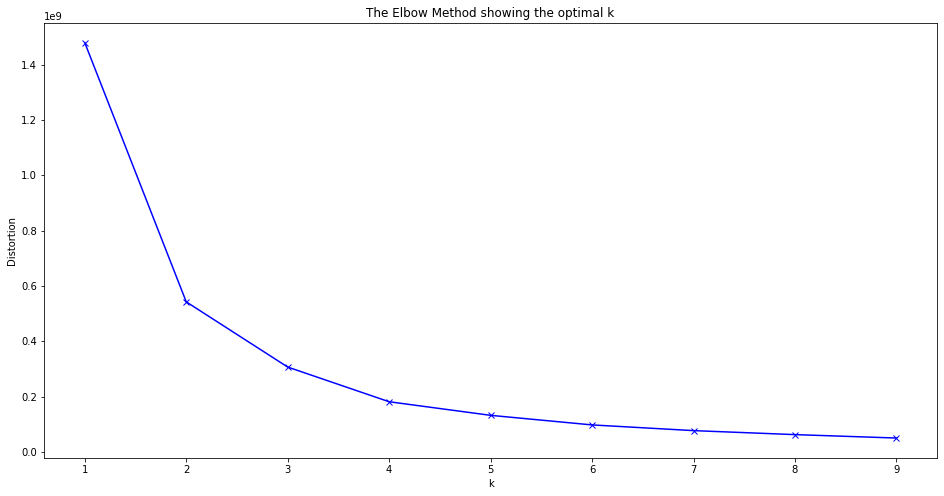

In [ ]:
#optimal cluster의 갯수를 구하기 위해 elbow method 이용
distortions = []
for k in range(1,10):
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(df_jangdan)
  distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
#그래프 결과, 4에서 elbow가 생기는걸 볼 수 있음

In [ ]:
kmeans = KMeans(n_clusters=4)

#위의 그래프 결과를 통해 4개의 cluster로 구분
y = kmeans.fit_predict(df_jangdan)

df_jangdan['jangdan_cluster'] = y
df_jangdan[['daytrading','swing','buy&hold']] = mirae[['daytrading','swing','buy&hold']]/100

print(df_jangdan.head())
#cluster 1, 3, 0, 2 순으로 장기, 중장기, 중기, 단기 보유 선호

   daytrading  swing  buy&hold  jangdan_cluster
1        0.00   0.00      1.00                1
2        0.00   1.00      0.00                0
3        0.02   0.74      0.24                3
4        0.00   0.81      0.19                0
5        0.41   0.57      0.01                2


In [ ]:
#주식 보유 기간 선호도 clustering 정보 저장
df_jangdan.to_csv('/content/drive/MyDrive/미래에셋/전처리/data/jangdan_cluster.csv')

# EDA

### 1. 매수량 탑 3 업종 통계 그래프

In [ ]:
upjong_price = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong_price.csv')

In [ ]:
#총 매수 업종(중분류) 1, 2, 3위 종합적으로 통계를 내봄
pd.concat([upjong_price['총매수1위업종'],upjong_price['총매수2위업종'],upjong_price['총매수3위업종']], axis = 0).value_counts()

제약과생물공학        151031
반도체와반도체장비      141647
자본재             89396
소재              73839
기술하드웨어와장비       71206
미디어             54575
소프트웨어와서비스       47757
자동차와부품          45100
운송              42086
전자와전기제품         35982
내구소비재와의류        29760
건강관리장비와서비스      20774
디스플레이           19668
에너지             18623
식품,음료,담배        17736
소매              10516
호텔,레스토랑,레저등      9419
은행               8818
다각화된금융           7296
증권               7209
보험               5362
통신서비스            5254
상업서비스와공급품        3321
가정용품과개인용품        2584
유틸리티             2580
교육서비스            2408
부동산              1844
식품과기본식료품소매        774
기타                410
dtype: int64

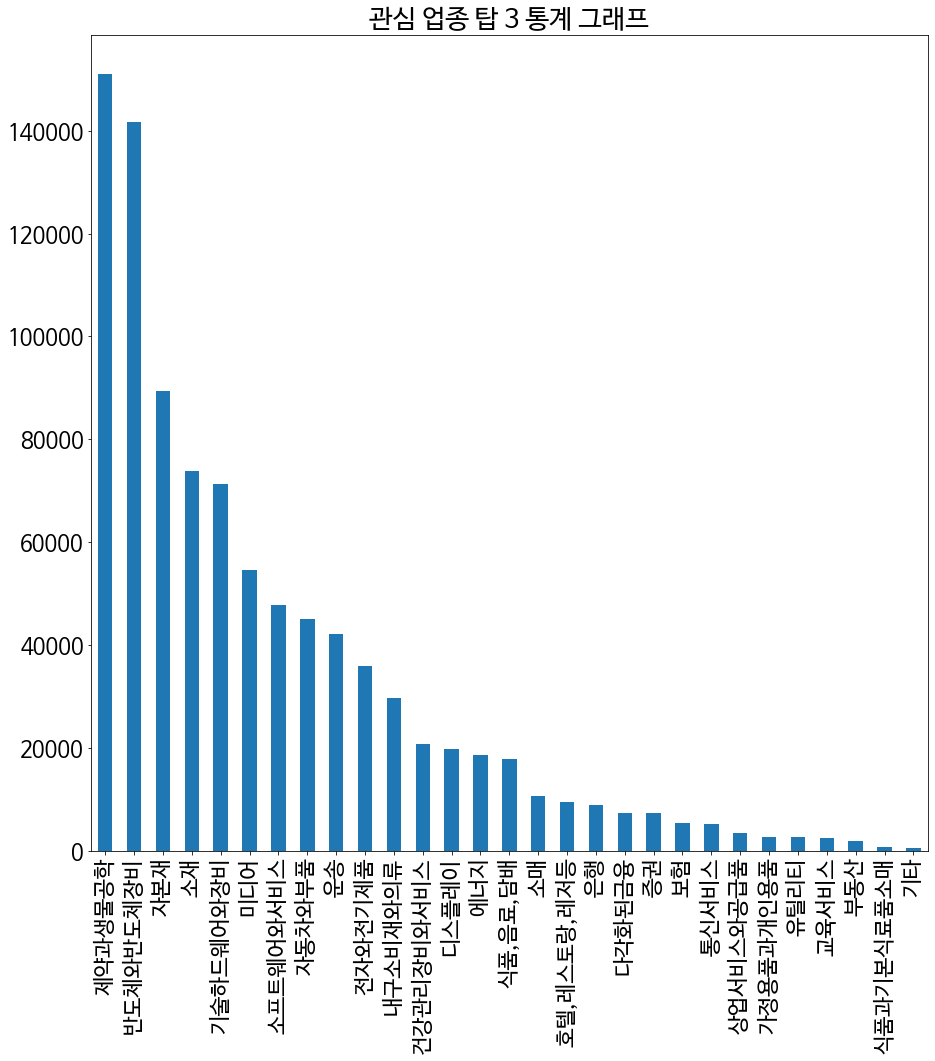

In [ ]:
#위의 통계를 바탕으로 그려본 그래프
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize = (15,15))
plt.title('관심 업종 탑 3 통계 그래프')
pd.concat([upjong_price['총매수1위업종'],upjong_price['총매수2위업종'],upjong_price['총매수3위업종']], axis = 0).value_counts().plot(kind = 'bar');

### 2. 선호 주식 보유 기간과 수익률의 상관관계

In [ ]:
#선호 주식 보유 기간 정보 불러오기
df_jangdan = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/jangdan_cluster.csv')

In [ ]:
#앞의 수익률 칼럼과 선호 주식 보유 기간 정보를 merge함
mirae_jangdan = pd.merge(mirae[['수익률']], df_jangdan[['jangdan_cluster']], left_index = True, right_index = True, how = 'left')[['수익률','jangdan_cluster']]
mirae_jangdan.dropna(inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



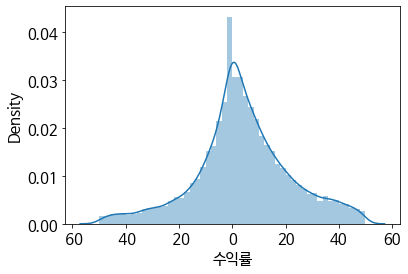

In [ ]:
#한글 폰트 불러오기
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 15})
plt.rc('font', family='NanumBarunGothic')
#cluster1(장기 보유 선호) 수익률 그래프
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 1]['수익률'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



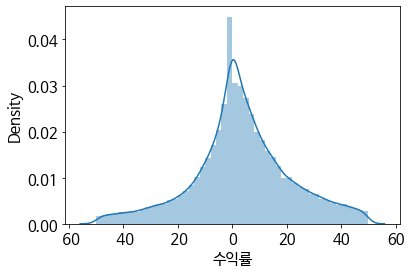

In [ ]:
#cluster2(단기 보유 선호) 수익률 그래프
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 2]['수익률'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

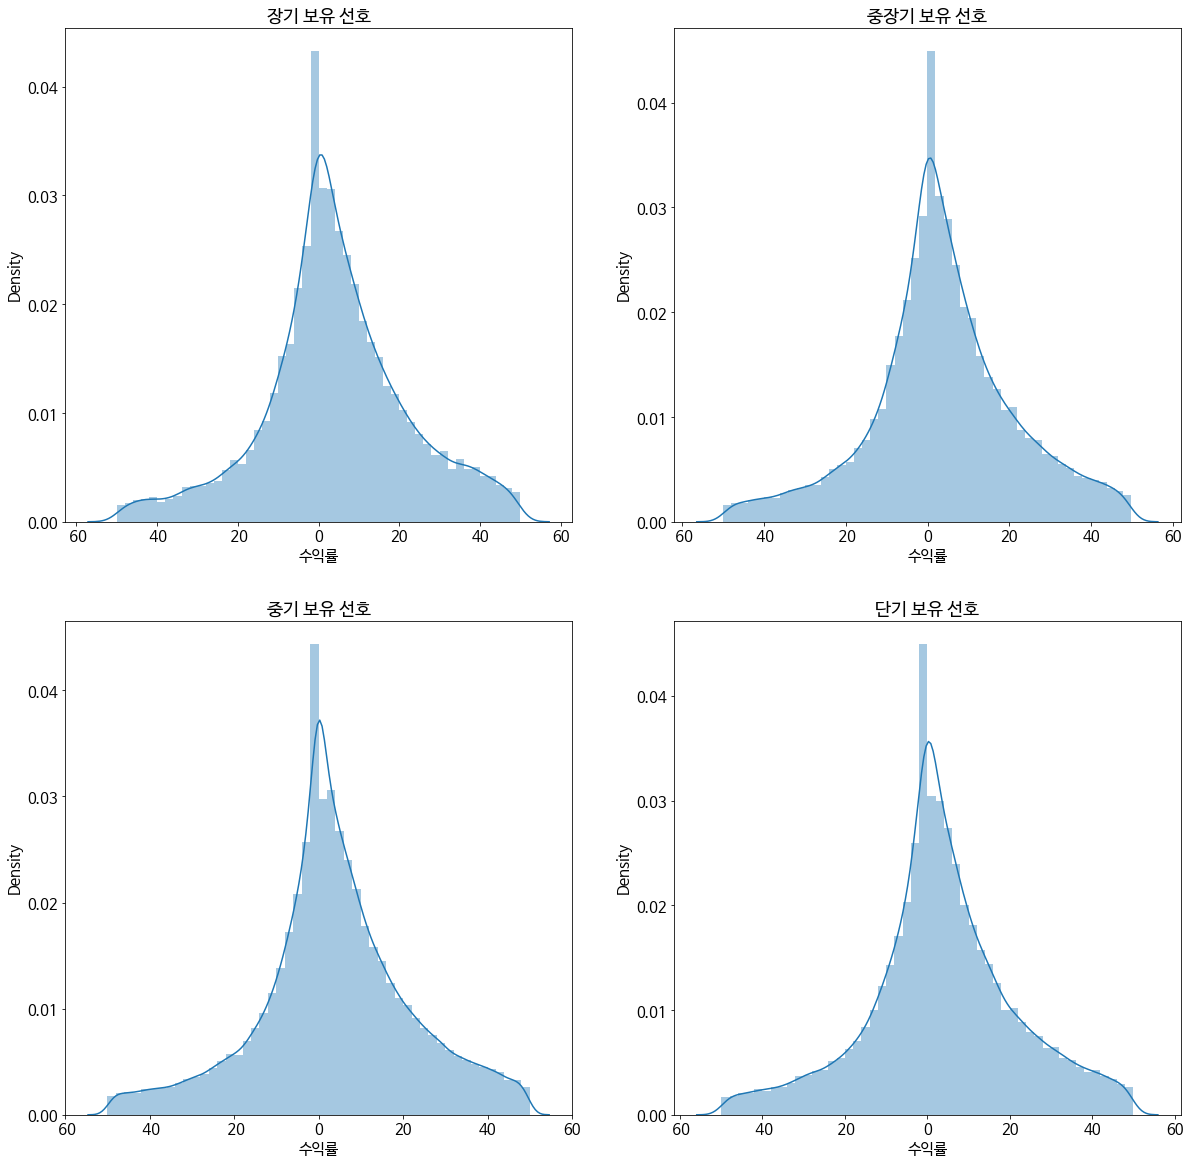

In [ ]:
#종합적으로 그래프 그리기
fig = plt.figure(figsize = (20,20))
area1 = fig.add_subplot(2,2,1)
area1.set_title('장기 보유 선호')
area2 = fig.add_subplot(2,2,2)
area2.set_title('중장기 보유 선호')
area3 = fig.add_subplot(2,2,3)
area3.set_title('중기 보유 선호')
area4 = fig.add_subplot(2,2,4)
area4.set_title('단기 보유 선호')

sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 1]['수익률'], ax = area1); #선호 보유 기간 : 장기
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 3]['수익률'], ax = area2); #선호 보유 기간 : 중장기
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 0]['수익률'], ax = area3); #선호 보유 기간 : 중기
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 2]['수익률'], ax = area4); #선호 보유 기간 : 단기

In [ ]:
#여전히 그래프로도 뚜렷한 차이가 보이지 않지만, 평균을 구해보면 차이가 존재함을 알 수 있다.
print(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 1]['수익률'].mean(), #
      mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 3]['수익률'].mean(),
      mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 0]['수익률'].mean(),
      mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 2]['수익률'].mean())
#선호 주식 보유 기간이 장기, 중장기, 중기, 단기 수익률로, 장기 수익률이 가장 큰 것으로 볼 수 있다.

4.0063839841085525 3.5842205945894396 3.619130288346842 3.36985208370457


- 이를 통해 안정적이고 지속 가능성이 뚜렷한 기업을 추천해줘 장기 보유를 유도한다면 안정적인 수익을 얻을 수 있을 것이라 생각했으며, 이와 관련된 서비스를 만들어볼 예정

### 3. 수익률이 높은 사람들의 업종 나열

In [ ]:
#업종별 총 매수금액 탑 3와 원래 미래에셋 데이터를 합쳐 새로운 dataframe 생성
upjong_price = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong_price.csv')
mirae = pd.concat([mirae, upjong_price], axis = 1)
price_upjong = mirae[['수익률','총매수1위업종','총매수2위업종','총매수3위업종']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



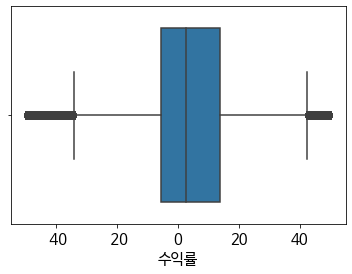

In [ ]:
#수익률 범위 나누기 위해 boxplot 그리기
sns.boxplot(price_upjong['수익률'])

In [ ]:
quant_pd=price_upjong[['수익률']].quantile([0.25, 0.5, 0.75])
# quant_pd
q1 = quant_pd.iloc[0][0]
q2 = quant_pd.iloc[1][0]
q3 = quant_pd.iloc[2][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: Us

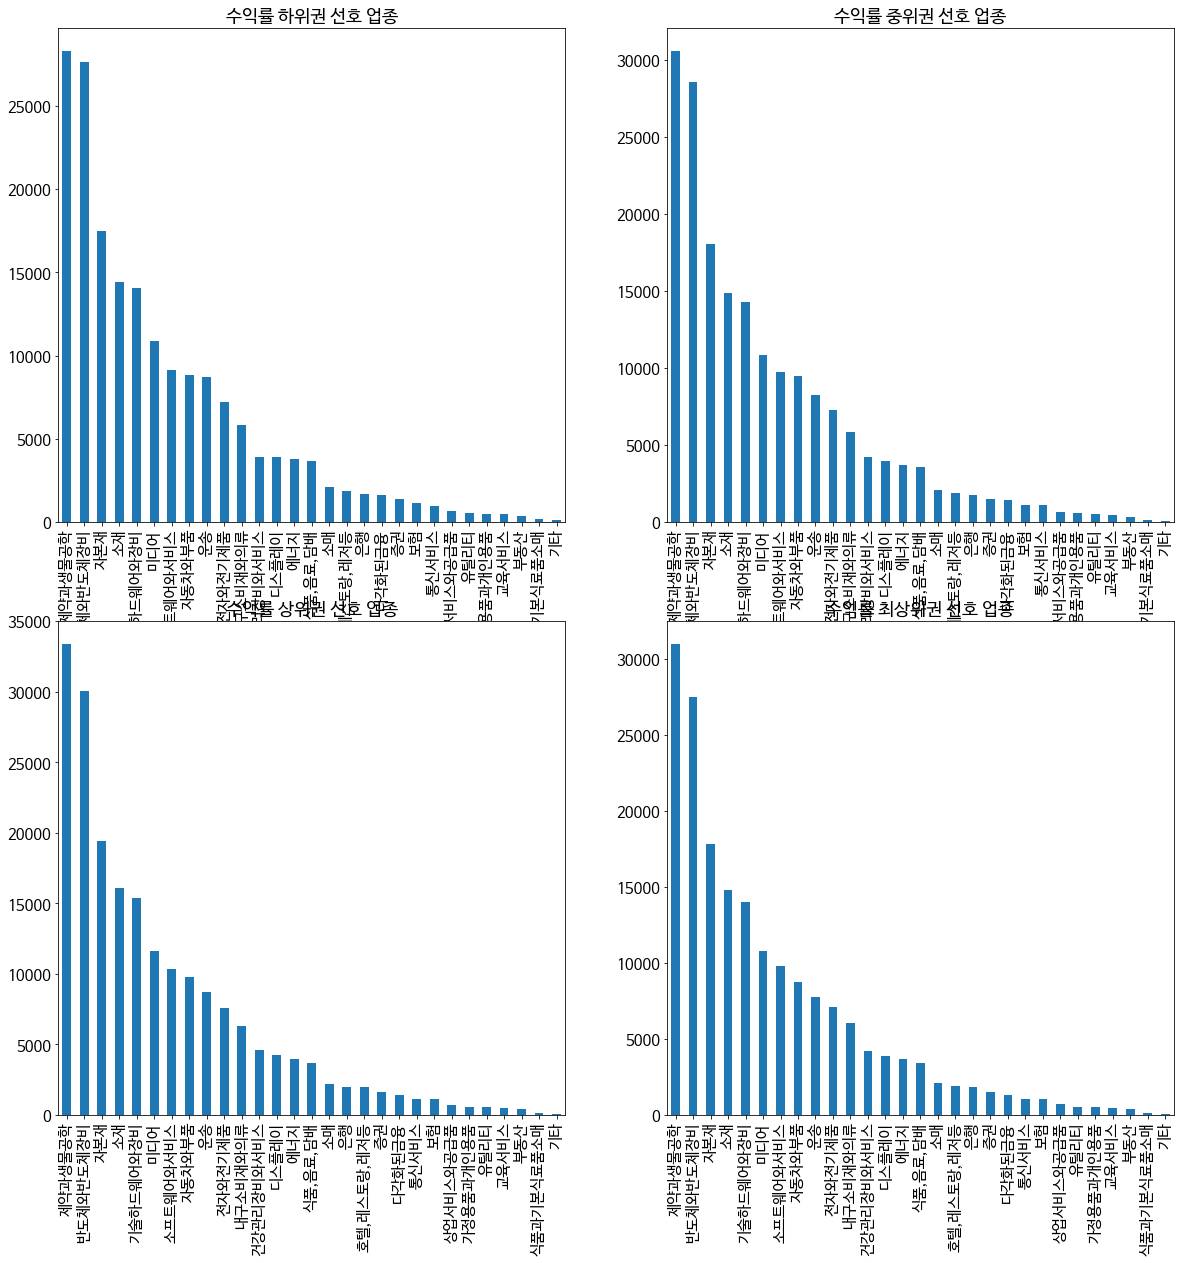

In [ ]:
fig = plt.figure(figsize = (20,20))
area1 = fig.add_subplot(2,2,1)
area1.set_title('수익률 하위권 선호 업종')
area2 = fig.add_subplot(2,2,2)
area2.set_title('수익률 중위권 선호 업종')
area3 = fig.add_subplot(2,2,3)
area3.set_title('수익률 상위권 선호 업종')
area4 = fig.add_subplot(2,2,4)
area4.set_title('수익률 최상위권 선호 업종')
plt.subplot(2,2,1)
pd.concat([price_upjong[price_upjong['수익률'] < q1]['총매수1위업종'],
           price_upjong[price_upjong['수익률'] < q1]['총매수2위업종'],
           price_upjong[price_upjong['수익률'] < q1]['총매수3위업종']], axis = 0).value_counts().plot(kind = 'bar')
plt.subplot(2,2,2)
pd.concat([price_upjong[price_upjong['수익률'] < q2 ][price_upjong['수익률']>q1]['총매수1위업종'],
           price_upjong[price_upjong['수익률'] < q2 ][price_upjong['수익률']>q1]['총매수2위업종'],
           price_upjong[price_upjong['수익률'] < q2 ][price_upjong['수익률']>q1]['총매수3위업종']], axis = 0).value_counts().plot(kind = 'bar')
plt.subplot(2,2,3)
pd.concat([price_upjong[price_upjong['수익률'] < q3 ][price_upjong['수익률']>q2]['총매수1위업종'],
           price_upjong[price_upjong['수익률'] < q3 ][price_upjong['수익률']>q2]['총매수2위업종'],
           price_upjong[price_upjong['수익률'] < q3 ][price_upjong['수익률']>q2]['총매수3위업종']], axis = 0).value_counts().plot(kind = 'bar')
plt.subplot(2,2,4)
pd.concat([price_upjong[price_upjong['수익률'] >q3]['총매수1위업종'],
           price_upjong[price_upjong['수익률'] >q3]['총매수2위업종'],
           price_upjong[price_upjong['수익률'] >q3]['총매수3위업종']], axis = 0).value_counts().plot(kind = 'bar')

수익률이 높은 집단이나 낮은 집단이나 모두 업종 선호도는 같은 형태를 띈다. 그러니 업종은 수익률과 관련이 있는 요소는 아니라고 볼 수 있으며, 관심 테마 내에서 좋은 종목을 추천해주면 높은 수익률을 기대해볼 수 있다.

# 서비스 기획 및 준비

### 시작하기에 앞서) 코스피 상위 500개 종목 불러오기

그 중 상위 100개 종목에 한해서만 일단 적용해볼 것

In [ ]:
!pip install -U finance-datareader # fdr 설치
!pip install --upgrade opendartreader # odr 설치
import FinanceDataReader as fdr
from google.colab import drive

In [ ]:
# 한국거래소 KOSPI 시세정보 - 한국 증권거래소 정보시스템에서 다운로드 (9월 12일 정보)
df_krx = pd.read_csv('/content/drive/MyDrive/미래에셋/kospi/KRX_전종목시세_0912.csv', sep = ",",encoding = 'CP949', error_bad_lines=False) 



# 한국거래소 KOSPI 종목정보
df_1 = fdr.StockListing('KOSPI')
df_2 = df_1[['Name', 'Sector']]
df_2 = df_2.rename(columns = {"Name" : "종목명", "Sector" : "업종"})
# print(df_2)



# KOSPI 전체종목 데이터와 시세정보 데이터 Outer Join
df_3 = pd.merge(df_krx, df_2, how='outer', on = '종목명')
# print(df_3)



# 시가총액 상위 500개 종목 추출
df_3 = df_3.sort_values(by = ['시가총액'], ascending = False)
df_4 = df_3.iloc[0:499] 
df_4 = df_4.reset_index(drop=True, inplace = False)
# 업종 정보 합치기
upjong = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong.csv', index_col = 0)
df_4 = pd.merge(df_4, upjong, how = 'left', left_on='종목명', right_on= '회사명', )
del df_4['회사명']
print(df_4.head())
df_4.to_csv("/content/drive/MyDrive/미래에셋/kospi/KOSPI_시가총액_상위500.csv", )


### 1. 기업의 ESG 관련 뉴스 분석을 통한 '비재무적 기업 가치' 측정

### 1) 6개월간의 ESG 뉴스기사 제목 데이터를 통해 뉴스기사 속 많이 등장하는 단어 구하기(워드클라우드 사용)

In [ ]:
import requests
from bs4 import BeautifulSoup
import datetime
from datetime import timedelta
import pandas as pd


# 뉴스기사 제목 저장 리스트
result = []


# 검색 파라미터 1
lastpage = 400
keyword  = "ESG"
sort = "0"


# 뉴스기사 제목 크롤링 
for m in range (0, 6):

    # 검색 파라미터 2
    s_date = datetime.date.today() + timedelta(days = -30 * (m+1))
    e_date = datetime.date.today() + timedelta(days = -30 * m)

    pageNum = 1

    for i in range (1, int(lastpage) * 10, 10):
        print(f"/{pageNum}페이지입니다/")
        response = requests.get(f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query={keyword}&sort=0&photo=0&field=0&pd=5&ds={s_date}&de={e_date}&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:1m,a:all&start={i}")
        html = response. text
        soup = BeautifulSoup(html, 'html.parser')
        links = soup.select(".news_tit")

        for link in links:
            title = link.text
            url = link.attrs['href']
            # print(title, url)
            result.append(title)
            # print(result)

        pageNum += 1


# CSV 저장
df_org = pd.DataFrame(result)
df_org.to_csv('/content/drive/MyDrive/미래에셋/ESG 키워드별 크롤링/data/ESG_뉴스제목_크롤링_6개월.csv', header = False, index = False)

In [ ]:
#필요 모듈 import
pip install konlpy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Twitter

In [ ]:
# 6개월 ESG 뉴스기사 제목 데이터 
df_org = pd.read_excel('/content/drive/MyDrive/미래에셋/ESG 키워드별 크롤링/data/ESG_뉴스제목_크롤링_6개월.xlsx')
# print(df_org.shape)


# 중복 뉴스 제목 제거
text = df_org.drop_duplicates()
# print(text.shape)

text.to_excel('중복제거_ESG_뉴스제목.xlsx', index = False, header = False)

In [ ]:
# Java 오류 해결
def _get_from_java_home(self):

    """
    Retrieves the Java library path according to the JAVA_HOME environment variable
    Returns:
        The path to the JVM library, or None 
    """

    # Get the environment variable
    # java_home = os.getenv("JAVA_HOME")
    java_home = "C:\Program Files\Java\jdk-17"
    if java_home and os.path.exists(java_home):
        # Get the real installation path
        java_home = os.path.realpath(java_home)

        if not os.path.exists(java_home):
            java_home = os.getenv("JAVA_HOME")

        # Look for the library file
        return self.find_libjvm(java_home)


In [ ]:
text = open('/content/drive/MyDrive/미래에셋/ESG 키워드별 크롤링/data/중복제거_ESG_뉴스제목.txt', encoding='cp949').read() 

# 워드 클라우드 제작
twitter = Twitter()

sentences_tag = []
sentences_tag = twitter.pos(text)

noun_adj_list = []

# tag가 명사이거나 형용사인 단어들만 noun_adj_list에 수집
for word, tag in sentences_tag:
    if tag in ['Noun', 'Adjective']:
        noun_adj_list.append(word)


# 빈출단어 상위 50개 저장
counts = Counter(noun_adj_list)
tags = counts.most_common(50)
print("//tags//")
print(tags)

# WordCloud 생성
wc = WordCloud(font_path = '/content/NanumSquareR.ttf', background_color = "white", max_font_size = 60)
cloud = wc.generate_from_frequencies(dict(tags))

# 생성된 WordCloud를 jpg로 저장
cloud.to_file('ESG_50.jpg')

### 저장된 워드클라우드(상위 50개 단어)


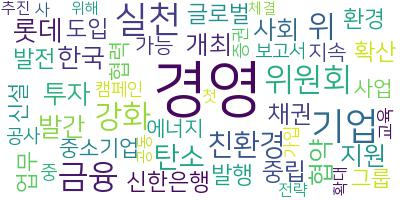

### 상위 100개 단어

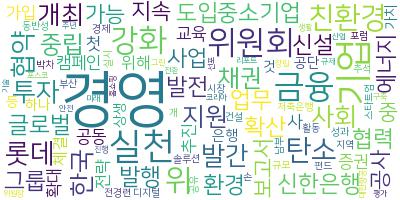

이 중, 많이 등장하고 중립적인 단어를 E, S, G 각각 3개씩 추출

E 관련 키워드 : '친환경', '탄소', '에너지'

S 관련 키워드 : '캠페인', '교육', '사회'

G 관련 키워드 : '위원회', '이사', '지배구조'

이 중 E 관련 키워드에 집중하여 키워드를 이용한 뉴스 감성분석을 통해 기업들의 ESG 관심도 중 E(환경) 관련 관심도를 구해봄.

In [ ]:
import pandas as pd
import numpy as np
import http


# 시가총액 상위 300개 기업리스트 (미래에셋 대우 API 미확인으로, 2021.09.12 기준 시총 상위 500개 중 300개 기업 사용)
df_4 = pd.read_csv("/content/drive/MyDrive/미래에셋/kospi/KOSPI_시가총액_상위500.csv")
lists_1 = df_4.loc[:100]
lists_2 = lists_1[['종목명']]


# ESG 키워드
ESG = {
'E_keyword' : ['친환경', '탄소', '에너지'],
'S_keyword' : ['캠페인', '교육', '사회'],
'G_keyword' : ['위원회', '이사', '지배구조']}
ESG_keyword = pd.DataFrame.from_dict(ESG)

print(ESG_keyword)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  E_keyword S_keyword G_keyword
0       친환경       캠페인       위원회
1        탄소        교육        이사
2       에너지        사회      지배구조


### 2) 키워드를 이용한 뉴스 크롤링

In [ ]:
# 지난 N개월 간의 종목명 + E 관련 뉴스기사 본문 추출
from multiprocessing import Pool
from bs4 import BeautifulSoup
import datetime
from datetime import timedelta
import urllib.request
from urllib.parse import quote
import pandas as pd


# 크롤링 메인 함수
def get_news(stock, keyword, query, sort, lastpage, period):

  stockName = stock
  ESGKeyword = keyword

  # 크롤링 결과 저장 데이터프레임
  news_df = pd.DataFrame(columns=("stockName", "ESGKeyword", "Title", "Article")) 

  idx = 0


  for month in range (0, period): # 해당 검색어(query)로 N(=period)개월치 기사 추출

    s_date = datetime.date.today() + timedelta(days = -30 * (month+1))
    e_date = datetime.date.today() + timedelta(days = -30 * month)

    pageNum = 1

    for i in range (1, int(lastpage)*10, 10):
      # print(f"/{pageNum}페이지입니다/")

      url_query = quote(query)
      url = f"https://search.naver.com/search.naver?where=news&sm=tab_jum&query={url_query}&sort=0&photo=0&field=0&pd=6&ds={s_date}&de={e_date}&nso=so:r,p:{period}m,a:all&start={i}"

      search_url = urllib.request.urlopen(url).read()
      soup = BeautifulSoup(search_url, 'html.parser')
      links = soup.find_all('div', {'class':'info_group'})
  

      # 하나의 검색 페이지 안에서의 반복
      for link in links:

        # '네이버 뉴스' 형식으로 작성된 기사만을 추출 (href 2번)
        news_urls = link.find_all('a')

        if (len(news_urls) == 1): # '네이버 뉴스' 형식 X
          continue

        else:  # '네이버 뉴스' 형식 O
          
          for news_url_test in news_urls:
            news_url = news_url_test.get('href')

          try:
            news_link = urllib.request.urlopen(news_url).read()
          except (http.client.IncompleteRead) as e:
            news_link = e.partial
          
          news_html = BeautifulSoup(news_link, 'html.parser')

          try: 
            title = news_html.find('h3', {'id': 'articleTitle'}).get_text()
            article = news_html.find('div', {'id': 'articleBodyContents'}).get_text()
            article = article.replace("// flash 오류를 우회하기 위한 함수 추가", "")
            article = article.replace("function _flash_removeCallback() {}", "")
            article = article.replace("\n","")
            article = article.replace("\t","")

            news_df.loc[idx] = [stockName, ESGKeyword, title, article]
            idx += 1

          except: 
            continue

          # print("#", end="")


      pageNum += 1


  return news_df




In [ ]:
# E(환경)부문


### 친환경 ###

# CONCAT 목적의 초기 데이터프레임 형성
default = {
'stockName' : ['Test'],
'ESGKeyword' : ['Test'],
'Title' : ['Test'],
'Article' : ['Test']}
df_default = pd.DataFrame.from_dict(default) 


# 파라미터 입력 후 크롤링
for i in range(100): # 시총 상위 100개 기업

  query = lists_2['종목명'].values[i] + "+" + ESG_keyword['E_keyword'].values[0]
  sort = "0" # 관련도 순 기사
  lastpage = 100 # 100 페이지까지 크롤링 (최대 400페이지까지 가능하기는 하나, 파일 크기 과부하 방지)
  period = 6 # 6개월간의 기사

  print(lists_2['종목명'].values[i])
  print(ESG_keyword['E_keyword'].values[0])
  print(i)
  
  df = get_news(lists_2['종목명'].values[i], ESG_keyword['E_keyword'].values[0], query, sort, lastpage, period)
  df_default = pd.concat([df_default, df], axis = 0)


df_default.head()
df_default.to_csv('E부문_친환경_1_100.csv', header = True, index = False)



### 탄소 ###

# CONCAT 목적의 초기 데이터프레임 형성
default = {
'stockName' : ['Test'],
'ESGKeyword' : ['Test'],
'Title' : ['Test'],
'Article' : ['Test']}
df_default = pd.DataFrame.from_dict(default) 


# 파라미터 입력 후 크롤링
for i in range(100): # 시총 상위 100개 기업

  query = lists_2['종목명'].values[i] + "+" + ESG_keyword['E_keyword'].values[1]
  sort = "0" # 관련도 순 기사
  lastpage = 100 # 100 페이지까지 크롤링 (최대 400페이지까지 가능하기는 하나, 파일 크기 과부하 방지)
  period = 6 # 6개월간의 기사

  print(lists_2['종목명'].values[i])
  print(ESG_keyword['E_keyword'].values[1])
  print(i)
  
  df = get_news(lists_2['종목명'].values[i], ESG_keyword['E_keyword'].values[1], query, sort, lastpage, period)
  df_default = pd.concat([df_default, df], axis = 0)


df_default.head()
df_default.to_csv('E부문_탄소_1_100.csv', header = True, index = False)



### 에너지 ###

# CONCAT 목적의 초기 데이터프레임 형성
default = {
'stockName' : ['Test'],
'ESGKeyword' : ['Test'],
'Title' : ['Test'],
'Article' : ['Test']}
df_default = pd.DataFrame.from_dict(default) 


# 파라미터 입력 후 크롤링
for i in range(100): # 시총 상위 100개 기업

  query = lists_2['종목명'].values[i] + "+" + ESG_keyword['E_keyword'].values[2]
  sort = "0" # 관련도 순 기사
  lastpage = 100 # 100 페이지까지 크롤링 (최대 400페이지까지 가능하기는 하나, 파일 크기 과부하 방지)
  period = 6 # 6개월간의 기사

  print(lists_2['종목명'].values[i])
  print(ESG_keyword['E_keyword'].values[2])
  print(i)
  
  df = get_news(lists_2['종목명'].values[i], ESG_keyword['E_keyword'].values[2], query, sort, lastpage, period)
  df_default = pd.concat([df_default, df], axis = 0)


df_default.head()
df_default.to_csv('E부문_에너지_1_100.csv', header = True, index = False)

### 3) KNU 한국어 감정사전을 통한 감성분석 진행
(출처:http://dilab.kunsan.ac.kr/knusl.html)


In [ ]:
import pandas as pd

# KNU 감정 사전
positive_word = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/pos_pol_word.txt")
negative_word = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/neg_pol_word.txt")

Positive = positive_word.transpose() # list(positive_word['word'])
Negative = negative_word.transpose() # list(negative_word['word'])

print(Positive)
print(Negative)

                                                    Keyword
Negative  결국 결함 공허한 과적 극심한 둔화 마이너스 몰수 미완성 배상 부적합한 부정적 부정...
Positive  가치 가치있는 강세 개선 개선된 개선되는 경신 경의 고급 기꺼이 더 좋은 도움이 되...


In [ ]:
# 부정
cols_n = []
for i in range(0, 9826): # 감정사전 내 부정어의 개수
  cols_n.append(i)
#print(cols_n)
Negative["Keyword"] = Negative[cols_n].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
Negative

In [ ]:
# 긍정 단어들
cols_n = []
for i in range(0, 4867): # 감정사전 내 긍정어의 개수
  cols_n.append(i)
#print(cols_n)
Positive["Keyword"] = Positive[cols_n].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
Positive

         종목명
0       삼성전자
1     SK하이닉스
2      NAVER
3   삼성바이오로직스
4      삼성전자우
..       ...
95      신풍제약
96    현대차2우B
97     GS리테일
98   일진머티리얼즈
99     SK케미칼

[100 rows x 1 columns]


### 3-1) 종목별 ESG 기사 및 불용어 업로드

코드의 양이 너무 많아지기 때문에 일단 탄소 키워드 코드만 업로드함. 나머지 '친환경', '에너지' 관련 코드는 '미래에셋/ESG점수' 폴더 안에 있으며 '미래에셋/ESG점수/data' 안에 산출된 점수 데이터가 나와 있다.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
# 종목명 분리
list_1 = pd.read_csv("/content/drive/MyDrive/미래에셋/kospi/KOSPI_시가총액_상위500.csv")
list_2 = list_1.loc[0:99] # 시총 상위 100개 기업
list_3 = list_2[['종목명']]
print(list_3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# E부문 '에너지' 크롤링 기사 로드 
df_E11 = pd.read_csv('/content/drive/MyDrive/미래에셋/ESG 키워드별 크롤링/data/E부문_탄소_1_25.csv')
df_E12 = pd.read_csv('/content/drive/MyDrive/미래에셋/ESG 키워드별 크롤링/data/E부문_탄소_25_50.csv')
df_E13 = pd.read_csv('/content/drive/MyDrive/미래에셋/ESG 키워드별 크롤링/data/E부문_탄소_50_100.csv')
df_E1 = pd.concat([df_E11, df_E12])
df_E1 = pd.concat([df_E1, df_E13])
print(df_E1.head())
#NULL값 확인
#df_E1['Article'].isnull().sum()



# 불용어 리스트 로드
nltk.download('punkt')
stopwords_list_full = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/한국어불용어100.txt", sep = "\t", names = ['Word', 'Code', 'Freq'])
stopwords_list = stopwords_list_full['Word']
stopwords = stopwords_list.values.tolist()




,stockName,ESGKeyword,Title,Article
0,Test,Test,Test,Test
1,삼성전자,친환경,삼성물산·에쓰오일 '사우디 수소동맹',수소 밸류체인 구축협약아람코 인프라로 수소 생산 그린암모니아로 운송 추진연료전지·바...
2,삼성전자,친환경,탄소섬유 생산 1조 투자·충전소 건립… “친환경은 프리미엄 브랜드 필수”,효성중공업이 지난해 8월 완공한 정부세종청사 수소충전소 설치 모습. 이 충전소는 서...
3,삼성전자,친환경,[김대호 박사의 오늘 기업·사람] 헝다그룹·삼성전자·카카오·한국조선해양,동영상 뉴스■ 경제와이드 모닝벨 '오늘 기업 오늘 사람' - 김대호 글로벌이코노믹연...
4,삼성전자,친환경,"SKIET, RE100 선언…""2025년 전체 전력 60% 친환경 전환""","SKIET 등 4곳, 신규 가입 선언 SKIET는 공장 지붕에 설치한 태양광 패..."


### 3-2) 종목별 기사본문 - 긍정/부정어 사전에 대한 코사인 유사도 평균 산출

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np
from numpy import dot
from numpy.linalg import norm
import re

(1, 48)
(1, 48)


In [ ]:
result = [] # 모든 종목에 대한 데이터프레임 데이터


for stockName in list_3['종목명']:
  df_E1_stock = (df_E1['stockName'] == stockName)
  df_E1_per = df_E1[df_E1_stock]
  df_E1_per = df_E1_per.reset_index(drop=True, inplace=False)
  #print(df_E1_per) 


  # 기사 본문에 대한 특수문자 제거
  def sub_special(sentence):
    return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', "", sentence)
  df_E1_Article = df_E1_per['Article'].apply(sub_special)
  cnt = len(df_E1_Article.index) # 해당 기간 동안의 기사 개수
  #print(cnt)


  # 기사 본문에 대한 불용어 제거 
  for i, document in enumerate(df_E1_Article):
      clean_words = [] 
      for word in nltk.tokenize.word_tokenize(document): 
          if word not in stopwords: #불용어 제거
              clean_words.append(word)
      #print("불용어 제거 완료")
      #print(i)
      #print(clean_words)     
      df_E1_Article[i] = ' '.join(clean_words)


  # 최종 기사 데이터프레임
  df_E1_Article = pd.DataFrame(df_E1_Article, columns=['Article'])
  #print(df_E1_Article)
  

  # 기사 본문에 대한 tf-idf 계산
  vectorizer = TfidfVectorizer()
  tfidf_article_matrix = vectorizer.fit_transform(df_E1_Article['Article'])
  #print(tfidf_article_matrix.shape)
  

  # 부정어에 대한 tf-idf 계산
  tfidf_negative_matrix = vectorizer.transform([Negative.at['word','Keyword']])
  #print(tfidf_negative_matrix.shape)

  # 긍정어에 대한 tf-idf 계산
  tfidf_positive_matrix = vectorizer.transform([Positive.at['word','Keyword']])
  #print(tfidf_positive_matrix.shape)

  # 각각의 감정사전과 기사 본문에 대한 코사인 유사도 산출
  print("#####")
  #print("기사본문 - 부정어 간 코사인 유사도 평균")
  cos_sim_n = linear_kernel(tfidf_article_matrix, tfidf_negative_matrix)
  #print("기사본문 - 긍정어 간 코사인 유사도 평균")
  cos_sim_p = linear_kernel(tfidf_article_matrix, tfidf_positive_matrix)
  
  result.append([cnt, np.mean(cos_sim_n),np.mean(cos_sim_p)]) # 관련 기사 개수, 부정어 유사도, 긍정어 유사도


In [ ]:
# 모든 종목에 대한 최종 데이터프레임
df_result = pd.DataFrame(data = result, columns = ['Article_cnt', 'Negative_sim', 'Positive_sim'])
df_result_fin = list_3.join(df_result, how='left')
df_result_fin = df_result_fin.rename(columns = {'종목명': 'Stock'})

print(df_result_fin)

### 3-3) 점수 매기기

1. 긍정 비율 > 부정 비율인 경우 ====> article 갯수 * ((긍정어 유사도 - 부정어 유사도) + 1)
2. 부정 비율 > 긍정 비율인 경우 ====> -(article 갯수 * ((긍정어 유사도 - 부정어 유사도) + 1))

이렇게 긍정 비율이 많고, article 갯수가 많은 경우는 높은 순위에, 부정 비율이 많은 경우는 낮은 순위에 갈 수 있도록 조치한다.

이것 또한 코드의 양 때문에 '탄소' 키워드만 써놨으며, '친환경'과 '에너지' 관련 코드는 '미래에셋/ESG점수'내에 따로 저장해놓음.

In [ ]:
# 종목별 점수 매기기

# 부정 유사도 > 긍정 유사도인 경우 확인
for i in range (0, 100):
  
  if df_result_fin.loc[i, 'Negative_sim'] > df_result_fin.loc[i, 'Positive_sim']: # 긍정 < 부정일 경우, 
    df_result_fin.loc[i,'Score'] = - df_result_fin.loc[i,'Article_cnt'] * (1 + (df_result_fin.loc[i,'Negative_sim'] - df_result_fin.loc[i,'Positive_sim'] ))


  else:  # 부정 < 긍정일 경우, 아티클 개수 * (1 + (긍정어 유사도 - 부정어 유사도))
    df_result_fin.at[i,'Score'] = df_result_fin.at[i,'Article_cnt'] * (1 + (df_result_fin.at[i,'Positive_sim'] - df_result_fin.at[i,'Negative_sim'] ))



# 종목별 랭킹 나열
df_result_fin = df_result_fin.sort_values(by=['Score'], axis=0, ascending = False)
df_result_fin = df_result_fin.reset_index (drop = True)

for i in range (0, 100):
  df_result_fin.at[i, 'Ranking'] = int(i+1)

print(df_result_fin)
df_result_fin.to_csv("E기사_탄소.csv", header = True, index = False)

MSCI Rating 구하기

In [ ]:
# ESG등급 데이터 로드 (총 7등급)
ratings = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/MSCI_ESG_Ratings_org.txt", sep = "\t", encoding = "CP949")

# 수치 변환 (AAA: 7 - CCC:1)
ratings = ratings.replace({'AAA':7, 'AA':6, 'A': 5, 'BBB': 4, 'BB':3, 'B':2, 'CCC':1})

# 결측값 채우기
ratings = ratings.fillna(4) # MSCI Ratings 분포 기준 Average 등급 = BBB(4.0)
ratings = ratings.astype({'esgRating' : 'int'})

ratings.to_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/MSCI_ESG_Ratings.csv")

### 4) 위의 각 ESG 관련 점수들을 종합하여 최종 점수 산출

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# ESG 점수 데이터프레임 로드
keyword_1 = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/E기사_친환경.csv")
keyword_2 = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/E기사_탄소.csv")
keyword_3 = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/E기사_에너지.csv")
ESG_ratings = pd.read_csv("/content/drive/MyDrive/미래에셋/ESG점수/data/MSCI_ESG_Ratings.csv")

stock = pd.read_csv("/content/drive/MyDrive/미래에셋/kospi/KOSPI_시가총액_상위500.csv")
stock = stock.loc[0:99]
ESG_SCORE = [] # 최종 점수


# 종목별 3가지 ESG 키워드 순위의 평균
for name in stock['종목명']:
  idx_1 = keyword_1.index[( keyword_1['Stock'] == name )].tolist()
  idx_2 = keyword_2.index[( keyword_2['Stock'] == name )].tolist()
  idx_3 = keyword_3.index[( keyword_3['Stock'] == name )].tolist()
  idx_4 = ESG_ratings.index[( ESG_ratings['stockName'] == name )].tolist()
  
  score = (keyword_1.at[idx_1[0], 'Ranking'] + keyword_2.at[idx_2[0], 'Ranking'] + keyword_3.at[idx_3[0], 'Ranking']) / 3 

  # MSCI 등급에 따른 추가 가중치
  score *= (1 + (ESG_ratings.at[idx_4[0], 'esgRating'] / 10))

  ESG_SCORE.append([name, score])

final = pd.DataFrame(ESG_SCORE, columns = ['Stock', 'Score'])
# print(final)


# 점수 min-max 정규화
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

ESG_final = final['Score']
ESG_final = minmax_norm(ESG_final)
ESG_final_norm = pd.concat([final, ESG_final], axis = 1)
ESG_final_norm.columns = ['Stock', 'Score', 'Score_norm']
print(ESG_final_norm)

In [ ]:
ESG_final_norm.to_csv('/content/drive/MyDrive/미래에셋/ESG점수/data/ESG_final_norm.csv')

### 2. 주식 보조 지표를 이용한 '재무적 기업 가치' 점수 책정



### 1) 종목 정보를 통해 기업 가치 지표 크롤링하기

동일 업종 PER은 NAVER에서 크롤링했으며 PER, ROE, EPS, EV/EBITDA는 fnguide에서 크롤링했음


In [ ]:
kospi = pd.read_csv('/content/drive/MyDrive/미래에셋/kospi/KOSPI_시가총액_상위500.csv', index_col = 0)
del kospi['업종']
kospi.head()

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,중분류,소분류
0,005930,삼성전자,75300.0,0.0,0.00,75300.0,75600.0,74800.0,10103212.0,7.600385e+11,4.495246e+14,5.969783e+09,반도체와반도체장비,반도체와반도체장비
1,000660,SK하이닉스,105000.0,2000.0,1.94,103500.0,105500.0,103000.0,1999369.0,2.087660e+11,7.644025e+13,7.280024e+08,반도체와반도체장비,반도체와반도체장비
2,035420,NAVER,410000.0,11000.0,2.76,398000.0,416500.0,398000.0,1326870.0,5.432771e+11,6.734799e+13,1.642634e+08,미디어,양방향미디어와서비스
3,207940,삼성바이오로직스,925000.0,12000.0,1.31,919000.0,935000.0,919000.0,59758.0,5.532594e+10,6.120262e+13,6.616500e+07,제약과생물공학,제약
4,005935,삼성전자우,70700.0,-1000.0,-1.39,71000.0,71300.0,70700.0,1169578.0,8.295213e+10,5.817809e+13,8.228867e+08,반도체와반도체장비,반도체와반도체장비


In [ ]:
#시가총액 1위부터 100위까지 시가총액, 상장주식수, PER, PBR, EPS 정보 가져오기
stock_pointer = []
for code in list(kospi['종목코드'])[:100]:
  url = 'https://finance.naver.com/item/main.naver?code={}'.format(code)
  res = requests.get(url)
  soup = BeautifulSoup(res.text, 'lxml')
  info_list = soup.find('table', attrs={'class':'per_table'})
  #동일업종 PER 정보 가져오기
  try:
    upjong_PER = float(soup.find_all('div', attrs={'class':'gray'})[1].find('em').text)
  except:
    upjong_PER = None
  #PBR 정보 가져오기
  info_list = soup.find('table', attrs={'class':'per_table'})
  if info_list == None:
    PBR = None
  else:
    info_list = info_list.find_all('tr')
    PBR = info_list[2].find('em').text #PBR
    if PBR == 'N/A':
      PBR = None
    elif PBR != 'N/A':
      PBR = float(PBR)
  url = 'https://comp.fnguide.com/SVO2/ASP/SVD_main.asp?pGB=1&gicode=A{}'.format(code)
  res = requests.get(url)
  soup = BeautifulSoup(res.text, 'lxml')
  #EPS, EV/EBITDA, ROE 정보 가져오기
  try:
    table = soup.find_all('table', attrs={'class':'us_table_ty1 h_fix zigbg_no th_topbdno'})[1]
  except:
    continue
  #EPS 정보 가져오기
  EPS = table.find('tbody').find_all('tr')[3].find('td').text
  if ',' in EPS:
    EPS = float(EPS.replace(',',''))
  elif EPS == '\xa0' or EPS == 'N/A':
    EPS = None
  elif len(EPS)>=2:
    EPS = float(EPS)
  #EV/EBITDA 정보 가져오기
  EBITDA = table.find('tbody').find_all('tr')[5].find('td').text
  if ',' in EBITDA:
    EBITDA = float(EBITDA.replace(',',''))
  elif EBITDA == '\xa0' or EBITDA == 'N/A':
    EBITDA = float('-inf')
  elif len(EBITDA) >= 2:
    EBITDA = float(EBITDA)
  #ROE 정보 가져오기
  ROE = table.find('tbody').find_all('tr')[6].find('td').text
  if ',' in ROE:
    ROE = float(ROE.replace(',',''))
  elif ROE == '\xa0' or ROE == 'N/A':
    ROE = None
  elif len(ROE)>=2:
    ROE = float(ROE)
    
  stock_pointer.append([code, PBR, EPS, ROE, EBITDA, upjong_PER])

#가져온 자료 가지고 dataframe 만들기
df_stock_pointer = pd.DataFrame(data = stock_pointer, columns = ['종목코드','PBR','EPS','ROE','EV/EBITDA','업종PER'])
df_stock_pointer = pd.merge(kospi[['시가','종목코드','종목명','중분류','소분류']],df_stock_pointer, how = 'left', on = '종목코드')[:100]
df_stock_pointer.dropna(inplace = True)
df_stock_pointer

,시가,종목코드,종목명,중분류,소분류,PBR,EPS,ROE,EV/EBITDA,업종PER
0,75300.0,005930,삼성전자,반도체와반도체장비,반도체와반도체장비,1.84,3841.0,9.99,8.33,13.91
1,103500.0,000660,SK하이닉스,반도체와반도체장비,반도체와반도체장비,1.25,6532.0,9.53,6.37,13.91
2,398000.0,035420,NAVER,미디어,양방향미디어와서비스,2.52,6097.0,15.21,28.61,7.09
3,919000.0,207940,삼성바이오로직스,제약과생물공학,제약,12.10,3642.0,5.38,125.21,101.06
5,127000.0,035720,카카오,미디어,양방향미디어와서비스,6.49,353.0,2.70,49.25,7.09
...,...,...,...,...,...,...,...,...,...,...
94,308500.0,014680,한솔케미칼,소재,화학,6.24,10864.0,24.50,12.46,15.82
95,70500.0,019170,신풍제약,제약과생물공학,제약,8.12,91.0,1.72,341.11,101.06
97,33950.0,007070,GS리테일,소매,백화점과일반상점,1.07,2187.0,7.49,6.09,42.52
98,77400.0,020150,일진머티리얼즈,기술하드웨어와장비,전자장비와기기,7.77,927.0,7.23,30.42,26.42


In [ ]:
#EV/EBITDA가 나오지 않은 종목들은 모두 작년 EV/EBITDA 정보를 부득이하게 가져왔습니다.
df_stock_pointer.loc[11,'EV/EBITDA'] = 198.72
df_stock_pointer.loc[16,'EV/EBITDA'] = 10.32
df_stock_pointer.loc[21,'EV/EBITDA'] = 20.33
df_stock_pointer.loc[22,'EV/EBITDA'] = 21.53
df_stock_pointer.loc[28,'EV/EBITDA'] = 10.95
df_stock_pointer.loc[31,'EV/EBITDA'] = 17.12
df_stock_pointer.loc[37,'EV/EBITDA'] = 6.08
df_stock_pointer.loc[38,'EV/EBITDA'] = 6.93
df_stock_pointer.loc[43,'EV/EBITDA'] = -207.90
df_stock_pointer.loc[49,'EV/EBITDA'] = 18.61
df_stock_pointer.loc[50,'EV/EBITDA'] = 72.04
df_stock_pointer.loc[58,'EV/EBITDA'] = 63.40
df_stock_pointer.loc[62,'EV/EBITDA'] = 19.71
df_stock_pointer.loc[66,'EV/EBITDA'] = 11.07
df_stock_pointer.loc[68,'EV/EBITDA'] = 16.35
df_stock_pointer.loc[75,'EV/EBITDA'] = 12.61
df_stock_pointer.loc[77,'EV/EBITDA'] = 5.58
df_stock_pointer.loc[79,'EV/EBITDA'] = -63.45
df_stock_pointer.loc[83,'EV/EBITDA'] = -12.73
df_stock_pointer.loc[84,'EV/EBITDA'] = 6.19	
df_stock_pointer.loc[85,'EV/EBITDA'] = 28.05
df_stock_pointer.loc[90,'EV/EBITDA'] = 19.76	
df_stock_pointer.loc[91,'EV/EBITDA'] = 17.99

### 3)크롤링한 자료를 바탕으로 점수 매기기

1. 적정 가격 : `EPS * 업종 PER`로 적정 가격을 책정한 후, 현재 시가가 적정 가격보다 높으면 고평가되어 있는 것이고, 현재 시가가 적정 가격보다 낮으면 저평가 되어 있다고 판단한다. 그래서 시가와 적정가격의 비율을 통해 `시가/적정가격`이 낮을수록 높은 순위를 매긴다.

2. EV/EBITDA : EV/EBITDA가 낮으면 인수 시 투자원금 회수가 빠르고 기업이 저평가되어 있다는 말이므로, 낮을수록 높은 순위를 매김

3. ROE : ROE가 높은 기업은 재무구조상 더 좋다고 판단되기 때문에 ROE가 높은 종목부터 높은 순위를 매긴다.

- 종합 점수 : `(len(df_stock_pointer)*3 - (RANK_평가 + RANK_EV/EBITDA + RANK_ROE)) / 3`를 minmax scaler로 표준화한 점수

In [ ]:
df_stock_pointer['적정가격'] = df_stock_pointer['EPS'] * df_stock_pointer['업종PER'] #EPS * 업종 PER로 적정 가격 책정
df_stock_pointer['시가/적정가격'] = df_stock_pointer['시가']/df_stock_pointer['적정가격'] #시가를 적정 가격으로 나눠서 얼마나 저평가/고평가 되었는지 추정
# PER의 순위 : PER이 낮으면 주가가 기업의 이익에 비해 저평가되었다 하므로 작은 순서부터 순위를 매김
df_stock_pointer['RANK_평가']  = df_stock_pointer['시가/적정가격'].rank(ascending=True)

# EV/EBITDA 순위 : EV/EBITDA가 낮으면 인수 시 투자원금 회수가 빠르고 기업이 저평가되어 있다는 말이므로, 낮을수록 높은 순위를 매김
df_stock_pointer['RANK_EV/EBITDA']  = df_stock_pointer['EV/EBITDA'].rank(ascending=True)

# ROE의 순위 : ROE가 높을수록 가치 있는 주식이라 판단, 순위를 매김
df_stock_pointer['RANK_ROE']  = df_stock_pointer['ROE'].rank(ascending=False)

#종합 점수 매기기
df_stock_pointer['VALUE_SCORE']  = (len(df_stock_pointer) * 3 - (df_stock_pointer['RANK_평가'] + df_stock_pointer['RANK_EV/EBITDA'] + df_stock_pointer['RANK_ROE']))/ 3

#종합 점수 순으로 정렬하기
df_stock_pointer = df_stock_pointer.sort_values(by=['VALUE_SCORE'], ascending= False)
df_stock_pointer.reset_index(drop = True, inplace = True)
df_stock_pointer.head()

,시가,종목코드,종목명,중분류,소분류,PBR,EPS,ROE,EV/EBITDA,업종PER,적정가격,시가/적정가격,RANK_평가,RANK_EV/EBITDA,RANK_ROE,VALUE_SCORE
0,42000.0,137310,에스디바이오센서,건강관리장비와서비스,건강관리장비와용품,2.95,6597.0,139.69,0.01,39.73,262098.81,0.160245,11.0,6.0,1.0,90.000000
1,465000.0,259960,크래프톤,소프트웨어와서비스,게임엔터테인먼트,13.78,13710.0,61.86,0.00,33.32,456817.20,1.017913,37.0,4.5,2.0,81.500000
2,199500.0,011780,금호석유,소재,화학,1.30,17405.0,20.18,5.37,15.82,275347.10,0.724540,25.0,18.0,7.0,79.333333
3,77300.0,021240,코웨이,내구소비재와의류,가정용기기와용품,3.21,5486.0,31.51,4.94,12.26,67258.36,1.149300,44.0,13.0,3.0,76.000000
4,143000.0,066570,LG전자,전자와전기제품,전자제품,1.43,10885.0,13.22,5.15,16.35,177969.75,0.803507,27.0,15.0,18.5,75.833333


In [ ]:
from sklearn.preprocessing import MinMaxScaler

#minmax scaler로 점수 표준화하기
minmax = MinMaxScaler()

minmax.fit(df_stock_pointer[['VALUE_SCORE']])
df_stock_pointer[['VALUE_SCORE']] = minmax.fit_transform(df_stock_pointer[['VALUE_SCORE']])
df_stock_pointer.head()

,시가,종목코드,종목명,중분류,소분류,PBR,EPS,ROE,EV/EBITDA,업종PER,적정가격,시가/적정가격,RANK_평가,RANK_EV/EBITDA,RANK_ROE,VALUE_SCORE
0,42000.0,137310,에스디바이오센서,건강관리장비와서비스,건강관리장비와용품,2.95,6597.0,139.69,0.01,39.73,262098.81,0.160245,11.0,6.0,1.0,1.000000
1,465000.0,259960,크래프톤,소프트웨어와서비스,게임엔터테인먼트,13.78,13710.0,61.86,0.00,33.32,456817.20,1.017913,37.0,4.5,2.0,0.895062
2,199500.0,11780,금호석유,소재,화학,1.30,17405.0,20.18,5.37,15.82,275347.10,0.724540,25.0,18.0,7.0,0.868313
3,77300.0,21240,코웨이,내구소비재와의류,가정용기기와용품,3.21,5486.0,31.51,4.94,12.26,67258.36,1.149300,44.0,13.0,3.0,0.827160
4,143000.0,66570,LG전자,전자와전기제품,전자제품,1.43,10885.0,13.22,5.15,16.35,177969.75,0.803507,27.0,15.0,18.5,0.825103


In [ ]:
df_stock_pointer.to_csv('/content/drive/MyDrive/미래에셋/기업 가치 점수/stock_pointer.csv')

# 종목 추천 시스템 개발

### 세가지 요소를 조합해서 추천

1. (비재무적) ESG 점수 : 위에서 구한 ESG 점수에 선호 보유 기간 clustering한 결과에 따라 가중치를 곱해준 후 더해줌
- 단기(cluster2), 중기(cluster0), 중장기(cluster3), 장기(cluster1) 보유 선호 순으로 각각 ESG 점수에 0.25, 0.5, 0.75, 1을 곱해준 후 더해줌


2. (재무적) 기업 가치 점수 : 위에서 구한 기업 가치 종합 점수를 더해줌

3. 선호 업종(중분류) : 앞에서 구한 선호 업종 탑3에 해당하는 업종들에게는 `총매수X위금액 / sum(총매수X위금액)` 만큼의 점수를 더해줌. 

In [ ]:
#데이터 준비하기
#미래에셋 데이터
mirae = pd.read_csv('/content/drive/MyDrive/미래에셋/mirae_stockname.csv', index_col = 0)
#업종(중분류, 소분류) 데이터
upjong_price = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/upjong_price.csv', index_col = 0)
#선호 보유 기간 cluster 데이터
df_jangdan = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/jangdan_cluster.csv')
#ESG 점수 데이터
ESG_final_norm = pd.read_csv('/content/drive/MyDrive/미래에셋/ESG점수/data/ESG_final_norm.csv', index_col = 0)
#기업 가치 점수 데이터
df_stock_pointer = pd.read_csv('/content/drive/MyDrive/미래에셋/기업 가치 점수/stock_pointer.csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
def stock_recommendation(idx):
  df_score = pd.merge(df_stock_pointer, ESG_final_norm, how = 'left', left_on = '종목명', right_on = 'Stock')
  df_jangdan_rename = df_jangdan.rename(columns = {'Unnamed: 0': 'ID'})
  
  # ESG 점수를 선호 보유기간에 따라 조정
  if idx in list(df_jangdan_rename['ID']):
    if list(df_jangdan_rename[df_jangdan_rename['ID'] == idx]['jangdan_cluster'])[0] == 2: #단기
      df_score['Score_norm'] = df_score['Score_norm'] * 0.25
    elif list(df_jangdan_rename[df_jangdan_rename['ID'] == idx]['jangdan_cluster'])[0] == 0: #중기
      df_score['Score_norm'] = df_score['Score_norm'] * 0.5
    elif list(df_jangdan_rename[df_jangdan_rename['ID'] == idx]['jangdan_cluster'])[0] == 3: #중장기
      df_score['Score_norm'] = df_score['Score_norm'] * 0.75
    elif list(df_jangdan_rename[df_jangdan_rename['ID'] == idx]['jangdan_cluster'])[0] == 1: #장기
      df_score['Score_norm'] = df_score['Score_norm']
  else: #결측치일 경우
    df_score['Score_norm'] = 0
  
  # 총 점수를 구함
  df_score['TOTAL_SCORE'] = df_score['Score_norm'] + df_score['VALUE_SCORE']
  
  # 앞에서 구한 선호 업종 탑3에 해당하는 업종들에게는 `총매수X위금액 / sum(총매수X위금액)` 만큼의 점수를 더해줌. 
  sum_price = upjong_price['총매수1위금액'][idx] + upjong_price['총매수2위금액'][idx] + upjong_price['총매수3위금액'][idx]
  if upjong_price['총매수1위금액'][idx] != 0:
    df_score.loc[df_score[df_score['중분류'] == upjong_price['총매수1위업종'][idx]].index,'TOTAL_SCORE'] += upjong_price['총매수1위금액'][idx] / sum_price
  if upjong_price['총매수2위금액'][idx] != 0:
    df_score.loc[df_score[df_score['중분류'] == upjong_price['총매수2위업종'][idx]].index,'TOTAL_SCORE'] += upjong_price['총매수2위금액'][idx] / sum_price
  if upjong_price['총매수3위금액'][idx] != 0:
    df_score.loc[df_score[df_score['중분류'] == upjong_price['총매수3위업종'][idx]].index,'TOTAL_SCORE'] += upjong_price['총매수3위금액'][idx] / sum_price
  
  # 구해준 점수에 따라 높은 점수부터 정렬
  df_score = df_score.sort_values(by=['TOTAL_SCORE'], ascending= False)
  df_score.reset_index(drop = True, inplace = True)

  ### 위에서 구한 종목 순위 기반, 이제껏 매수했던 종목들과 겹치지 않는 종목을 추천해주기
  
  mirae_stock_list = []
  mirae_columns = list(mirae.columns)
  for x in mirae_columns:
    if '주식매수' in x:
      if len(x) > 13 and not '금액' in x:
        mirae_stock_list.append(x)

  # 이제껏 매수해온 종목들 구하기
  maesu_stock = []
  for s in mirae_stock_list:
    maesu_stock.append(mirae[s][idx])
  maesu_stock = list(set(maesu_stock))

  # 이제 순위에서, 이제껏 매수해온 종목이 아닌 종목들만 높은 순위부터 3개 추천해주기
  recommandation = []
  rank = 0
  while True:
    if df_score['종목명'][rank] not in maesu_stock:
      recommandation.append(df_score['종목명'][rank])
    rank += 1
    if len(recommandation) == 3:
      break
  
  return recommandation

In [ ]:
#미래에셋 데이터 내의 모든 사람들에게 주식 종목 추천
for i in range(0,30):
  print(stock_recommendation(i))

['에스디바이오센서', '크래프톤', '금호석유']
['삼성전기', 'LG이노텍', '에스디바이오센서']
['금호석유', '에스디바이오센서', '크래프톤']
['한진칼', '에스디바이오센서', '메리츠화재']
['하이브', '에스디바이오센서', 'NAVER']
['SK바이오팜', '유한양행', '에스디바이오센서']
['에스디바이오센서', '메리츠화재', 'DB손해보험']
['에스디바이오센서', '메리츠화재', 'DB손해보험']
['LG이노텍', '삼성전기', '에스디바이오센서']
['GS리테일', '이마트', 'KCC']
['에스디바이오센서', '메리츠화재', '코웨이']
['코웨이', 'LG생활건강', '에스디바이오센서']
['삼성전기', 'LG이노텍', '에스디바이오센서']
['에스디바이오센서', '한진칼', '유한양행']
['유한양행', 'SK바이오팜', '녹십자']
['에스디바이오센서', '메리츠화재', 'DB손해보험']
['에스디바이오센서', '메리츠화재', 'DB손해보험']
['한진칼', '현대글로비스', '에스디바이오센서']
['KCC', '두산밥캣', '에스디바이오센서']
['한국타이어앤테크놀로지', '에스디바이오센서', 'KCC']
['KCC', '두산밥캣', '에스디바이오센서']
['LG이노텍', '에스디바이오센서', '한국타이어앤테크놀로지']
['유한양행', 'SK바이오팜', '녹십자']
['유한양행', '녹십자', 'SK바이오팜']
['금호석유', '에스디바이오센서', '한솔케미칼']
['에스디바이오센서', '유한양행', 'SK바이오팜']
['유한양행', 'SK바이오팜', '에스디바이오센서']
['에스디바이오센서', '크래프톤', '금호석유']
['금호석유', '에스디바이오센서', '크래프톤']
['SK하이닉스', '에스디바이오센서', '메리츠화재']


### 이렇게 개인마다 다른 업종을 추천받을 수 있는 시스템을 구현해냄

### 읽어주셔서 감사합니다